Mounting and Export

In [3]:
# load folder gdrive /content/drive/MyDrive/HSLU/CV/Project and go to this

import os

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Change directory to the specified folder
os.chdir('/content/drive/MyDrive/HSLU/CV/Project')

# Verify the current working directory
print(os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/HSLU/CV/Project


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
!ls

emnist-balanced-mapping.txt  emnist-letters-mapping.txt  emnist-letters-train.csv
emnist-balanced-test.csv     emnist-letters-test.csv	 Untitled0.ipynb


## Letters datasets with combined classes (Upper-case and lower-case letters)

The EMNIST Letters dataset merges a balanced set of the uppercase and lowercase letters into a single 26-class task.

train: 88,800
test: 14,800
total: 103,600
classes: 37

Loading

In [5]:

def load_image_data_from_csv(csv_file_path):
  """
  Returns:
  A tuple with labels and images
  """

  df = pd.read_csv(csv_file_path)
  labels = np.array(df.iloc[:, 0].tolist())
  pixel_data = df.iloc[:, 1:].values
  images = np.array([np.transpose(np.reshape(row, (28, 28))) for row in pixel_data])
  return labels, images


# labels, images = load_image_data_from_csv('emnist-letters-train.csv')

# print(labels[0])  # Print the label of the first image
# print(images[0])  # Print the pixel data of the first image (28x28 array)

In [4]:
# Load training and test data
train_labels, train_images = load_image_data_from_csv('emnist-letters-train.csv')
test_labels, test_images = load_image_data_from_csv('emnist-letters-test.csv')


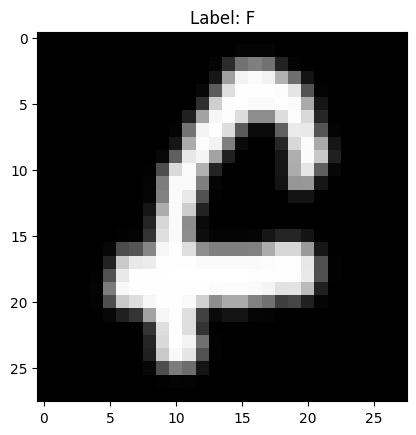

In [5]:
image_index = 99

# Display the image
plt.imshow(train_images[image_index], cmap='gray')
plt.title(f"Label: {chr(train_labels[image_index]+64)}") #label into character
plt.show()

In [6]:
# Normalize the images
train_images = train_images / 255.0
test_images = test_images / 255.0

# Simple CNN architecture
model1 = models.Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(27, activation='softmax')  # 26 letters + 1 extra class
])

# Compile the model
model1.compile(optimizer='adam',
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

# Train the model
model1.fit(train_images, train_labels, epochs=5, batch_size=64, validation_data=(test_images, test_labels))

# Evaluate the model
test_loss, test_acc = model1.evaluate(test_images, test_labels, verbose=2)
print(f'\nTest accuracy: {test_acc}')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.6705 - loss: 1.1120 - val_accuracy: 0.8627 - val_loss: 0.4231
Epoch 2/5
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8882 - loss: 0.3467 - val_accuracy: 0.8888 - val_loss: 0.3401
Epoch 3/5
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9111 - loss: 0.2705 - val_accuracy: 0.8988 - val_loss: 0.3141
Epoch 4/5
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9211 - loss: 0.2376 - val_accuracy: 0.8950 - val_loss: 0.3166
Epoch 5/5
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9290 - loss: 0.2130 - val_accuracy: 0.9060 - val_loss: 0.2868
463/463 - 1s - 3ms/step - accuracy: 0.9060 - loss: 0.2868

Test accuracy: 0.9060071706771851


90% of accuracy on the first run, not that bad. Where are mistakes?

In [7]:
# Predict labels for the test set
predicted_labels = np.argmax(model1.predict(test_images), axis=1)
# Convert numerical labels to characters
predicted_chars = [chr(label + 64) for label in predicted_labels]
true_chars = [chr(label + 64) for label in test_labels]

463/463 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


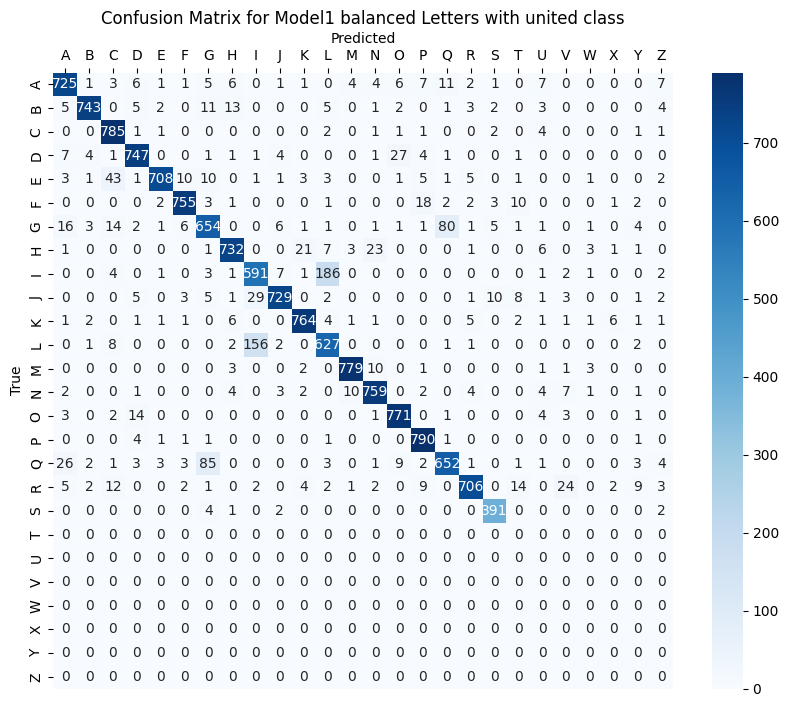

In [10]:
# confusion matrix
conf_matrix = confusion_matrix(true_chars, predicted_chars)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(list(set(predicted_chars))), yticklabels=list('ABCDEFGHIJKLMNOPQRSTUVWXYZ'))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Model1 balanced Letters with united class')
plt.gca().xaxis.tick_top()  # Move x-axis to top
plt.gca().xaxis.set_label_position('top')  # Move x-axis label to top
plt.show()

L was interpreted as I and other way around, obviously because that differnce would be hardly recognized even by human, actually there is no difference :) Let's see on some examples

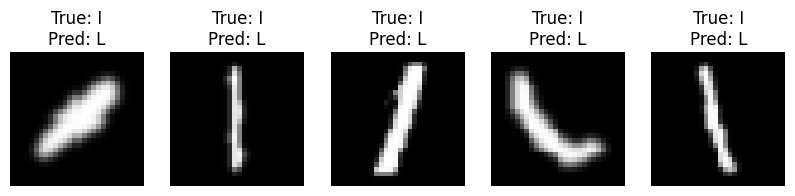

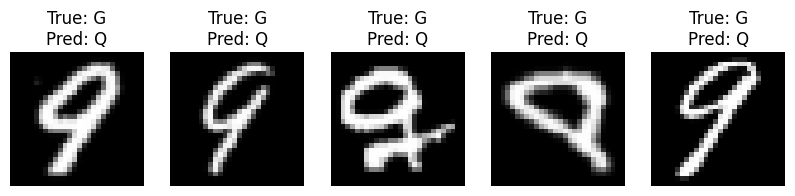

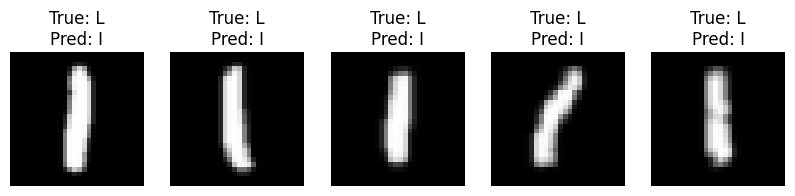

In [11]:
# Function to display a misclassified image
def show_misclassified_images(true_chars, predicted_chars, test_images, true_char, pred_char, num_images=5):
    misclassified_indices = [i for i, (true, pred) in enumerate(zip(true_chars, predicted_chars)) if true == true_char and pred == pred_char]

    # Plot the first few misclassified images
    plt.figure(figsize=(10, 10))
    for i, index in enumerate(misclassified_indices[:num_images]):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(test_images[index].reshape(28, 28), cmap='gray')
        plt.title(f"True: {true_char}\nPred: {pred_char}")
        plt.axis('off')
    plt.show()

# Show misclassified 'I' as 'L'
show_misclassified_images(true_chars, predicted_chars, test_images, 'I', 'L')

# Show misclassified 'G' as 'Q'
show_misclassified_images(true_chars, predicted_chars, test_images, 'G', 'Q')

# Show misclassified 'I' as 'L'
show_misclassified_images(true_chars, predicted_chars, test_images, 'L', 'I')

Ok, l and I seem to be undisinguishable. But with g and q it seems that it could be improved. Let's try a bit more complicated model

In [12]:
# another architecture with additional layers

# # Normalize the images
# train_images = train_images / 255.0
# test_images = test_images / 255.0

# CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(27, activation='softmax')  # 26 letters + 1 for background/unknown
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# # Reshape images to include channel dimension (1 for grayscale)
# train_images = train_images.reshape((train_images.shape[0], 28, 28, 1))
# test_images = test_images.reshape((test_images.shape[0], 28, 28, 1))

# Train the model
model.fit(train_images, train_labels, epochs=5, batch_size=64, validation_data=(test_images, test_labels))

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f'\nTest accuracy: {test_acc}')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.6822 - loss: 1.0708 - val_accuracy: 0.8791 - val_loss: 0.3653
Epoch 2/5
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9046 - loss: 0.2864 - val_accuracy: 0.9005 - val_loss: 0.2896
Epoch 3/5
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9240 - loss: 0.2221 - val_accuracy: 0.9156 - val_loss: 0.2496
Epoch 4/5
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9346 - loss: 0.1882 - val_accuracy: 0.9116 - val_loss: 0.2582
Epoch 5/5
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9406 - loss: 0.1710 - val_accuracy: 0.9179 - val_loss: 0.2428
463/463 - 1s - 2ms/step - accuracy: 0.9179 - loss: 0.2428

Test accuracy: 0.9178998470306396


Ok, now it is a bit better, so where is an error?

In [ ]:
# Predict labels for the test set
predicted_labels = np.argmax(model.predict(test_images, verbose = 0), axis=1)
# Convert numerical labels to characters
predicted_chars = [chr(label + 64) for label in predicted_labels]
true_chars = [chr(label + 64) for label in test_labels]

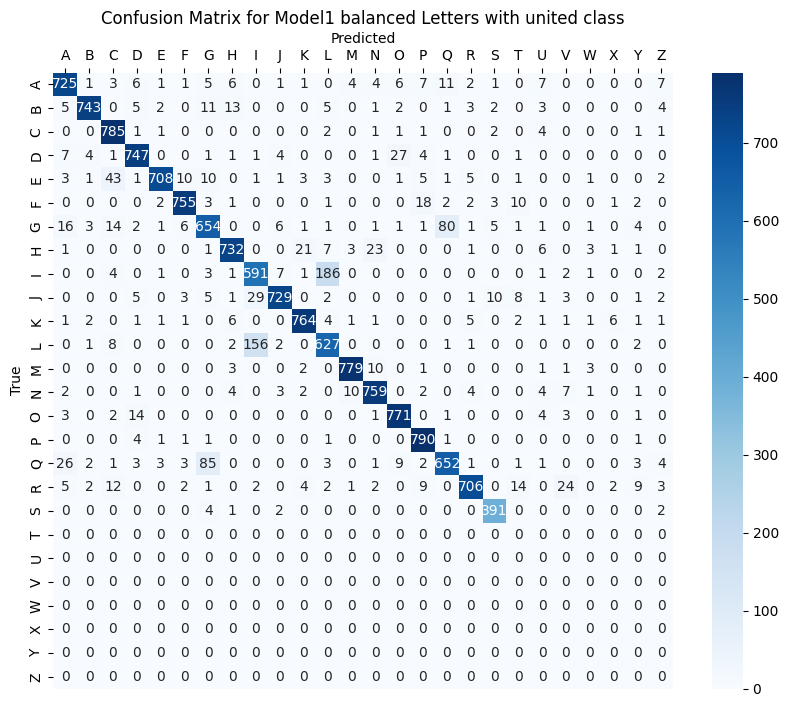

In [13]:
conf_matrix = confusion_matrix(true_chars, predicted_chars)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(list(set(predicted_chars))), yticklabels=list('ABCDEFGHIJKLMNOPQRSTUVWXYZ'))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Model1 balanced Letters with united class')
plt.gca().xaxis.tick_top()  # Move x-axis to top
plt.gca().xaxis.set_label_position('top')  # Move x-axis label to top
plt.show()

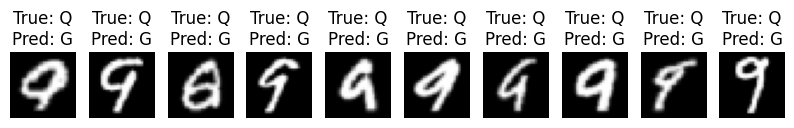

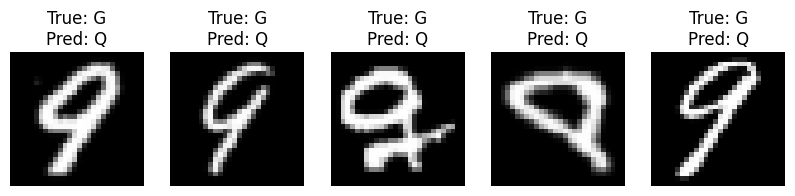

In [14]:
# Show misclassified 'Q' as 'G'
show_misclassified_images(true_chars, predicted_chars, test_images, 'Q', 'G', num_images = 10)

# Show misclassified 'G' as 'Q'
show_misclassified_images(true_chars, predicted_chars, test_images, 'G', 'Q')


What if we will not combine Upper and lower cases in one class?

## Separate classes for Upper and lower cases

In [6]:
# Load training and test data
train_labels, train_images = load_image_data_from_csv('emnist-balanced-train.csv')
test_labels, test_images = load_image_data_from_csv('emnist-balanced-test.csv')

In [7]:
# get real characters for labels, find mapping from emnist-balanced-mapping.txt where in first column is label and in second is ascii code

# read emnist-balanced-mapping.txt as dictionary where first column is key and second is value

mapping = {}
with open('emnist-balanced-mapping.txt', 'r') as file:
    for line in file:
        key, value = line.strip().split()
        mapping[key] = chr(int(value))

print(len(mapping))

mapping


47


{'0': '0',
 '1': '1',
 '2': '2',
 '3': '3',
 '4': '4',
 '5': '5',
 '6': '6',
 '7': '7',
 '8': '8',
 '9': '9',
 '10': 'A',
 '11': 'B',
 '12': 'C',
 '13': 'D',
 '14': 'E',
 '15': 'F',
 '16': 'G',
 '17': 'H',
 '18': 'I',
 '19': 'J',
 '20': 'K',
 '21': 'L',
 '22': 'M',
 '23': 'N',
 '24': 'O',
 '25': 'P',
 '26': 'Q',
 '27': 'R',
 '28': 'S',
 '29': 'T',
 '30': 'U',
 '31': 'V',
 '32': 'W',
 '33': 'X',
 '34': 'Y',
 '35': 'Z',
 '36': 'a',
 '37': 'b',
 '38': 'd',
 '39': 'e',
 '40': 'f',
 '41': 'g',
 '42': 'h',
 '43': 'n',
 '44': 'q',
 '45': 'r',
 '46': 't'}

In [17]:
str(np.unique(train_labels))

[mapping[str(label)] for label in np.unique(train_labels)]

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'a',
 'b',
 'd',
 'e',
 'f',
 'g',
 'h',
 'n',
 'q',
 'r',
 't']

In [ ]:
# with open('emnist-balanced-mapping.txt', 'r') as file:
#     for line in file:
#       key, value = line.strip().split()
#       print(int(key) - int(value))

-48
-48
-48
-48
-48
-48
-48
-48
-48
-48
-55
-55
-55
-55
-55
-55
-55
-55
-55
-55
-55
-55
-55
-55
-55
-55
-55
-55
-55
-55
-55
-55
-55
-55
-55
-55
-61
-61
-62
-62
-62
-62
-62
-67
-69
-69
-70


In [53]:
# # Normalize the images
# train_images = train_images / 255.0
# test_images = test_images / 255.0

# CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(47, activation='softmax')  # 37 distinct letters + 10 digits
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(train_images, train_labels, epochs=5, batch_size=64, validation_data=(test_images, test_labels))

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f'\nTest accuracy: {test_acc}')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
1763/1763 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.5488 - loss: 1.9588 - val_accuracy: 0.8191 - val_loss: 0.5541
Epoch 2/5
1763/1763 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8398 - loss: 0.4680 - val_accuracy: 0.8465 - val_loss: 0.4624
Epoch 3/5
1763/1763 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8612 - loss: 0.3937 - val_accuracy: 0.8505 - val_loss: 0.4354
Epoch 4/5
1763/1763 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8698 - loss: 0.3616 - val_accuracy: 0.8601 - val_loss: 0.4227
Epoch 5/5
1763/1763 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8761 - loss: 0.3376 - val_accuracy: 0.8561 - val_loss: 0.4181
588/588 - 2s - 3ms/step - accuracy: 0.8561 - loss: 0.4181

Test accuracy: 0.8561093807220459


That is even slightly worse. Where problems?

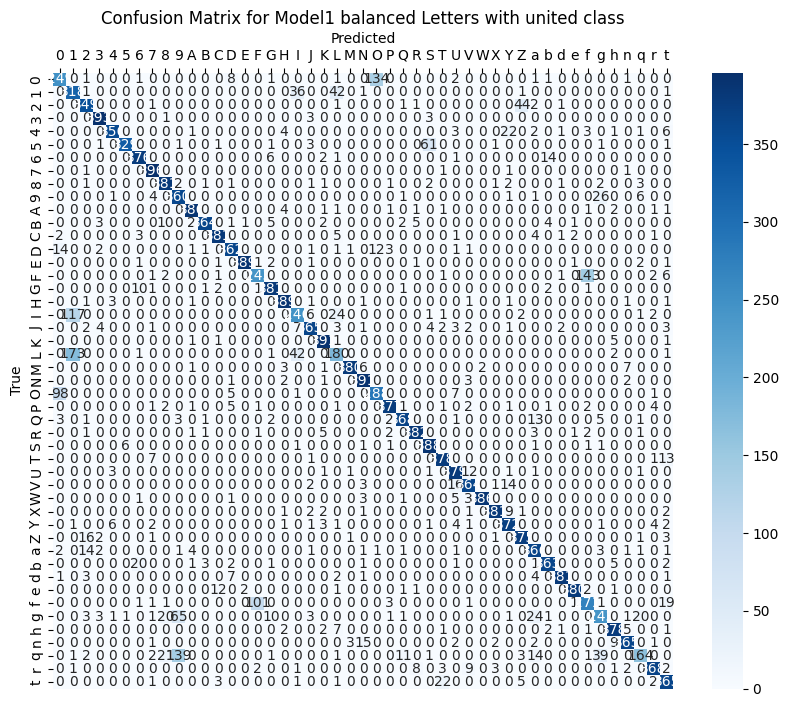

In [24]:
# Predict labels for the test set
predicted_labels = np.argmax(model.predict(test_images, verbose = 0), axis=1)
# Convert numerical labels to characters
predicted_chars = [mapping[str(label)] for label in predicted_labels]
true_chars = [mapping[str(label)] for label in test_labels]

conf_matrix = confusion_matrix(true_chars, predicted_chars)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(list(set(predicted_chars))), yticklabels=sorted(list(set(true_chars))))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Model1 balanced Letters with united class')
plt.gca().xaxis.tick_top()  # Move x-axis to top
plt.gca().xaxis.set_label_position('top')  # Move x-axis label to top
plt.show()

Obviously we have now problems with 1 and 0 which are highlu similart to l, I and O. What if we exclude them?

In [54]:
print(len(np.unique(train_labels)))
print(len(np.unique(test_labels)))
print(len(train_labels))
print(len(test_labels))
print(len(train_images))
print(len(test_images))

47
47
112799
18799
112799
18799


### Only letters

In [8]:


# excluding numbers train_labels, train_images, test_labels, test_images with lavels <10

train_mask = np.where(train_labels >= 10)
test_mask = np.where(test_labels >= 10)

train_labels = train_labels[train_mask]
train_images = train_images[train_mask]
test_labels = test_labels[test_mask]
test_images = test_images[test_mask]

In [56]:
print(len(np.unique(train_labels)))
print(len(np.unique(test_labels)))
print(len(train_labels))
print(len(test_labels))
print(len(train_images))
print(len(test_images))

37
37
88799
14799
88799
14799


In [9]:
# execute necesseraly! to avoid errors
train_labels -= 10
test_labels -= 10

In [59]:
# # Normalize the images
train_images = train_images / 255.0
test_images = test_images / 255.0


# CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(37, activation='softmax')  # 37 distinct letters
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_images, train_labels, epochs=20, batch_size=64, validation_data=(test_images, test_labels))

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f'\nTest accuracy: {test_acc}')


Epoch 1/5
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6451 - loss: 1.2632 - val_accuracy: 0.8772 - val_loss: 0.4006
Epoch 2/5
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.8872 - loss: 0.3505 - val_accuracy: 0.8902 - val_loss: 0.3398
Epoch 3/5
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9071 - loss: 0.2814 - val_accuracy: 0.8988 - val_loss: 0.3156
Epoch 4/5
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9164 - loss: 0.2507 - val_accuracy: 0.9009 - val_loss: 0.3047
Epoch 5/5
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9214 - loss: 0.2264 - val_accuracy: 0.9018 - val_loss: 0.3010
463/463 - 1s - 2ms/step - accuracy: 0.9018 - loss: 0.3010

Test accuracy: 0.9017501473426819


90% again where are errors? Let's see

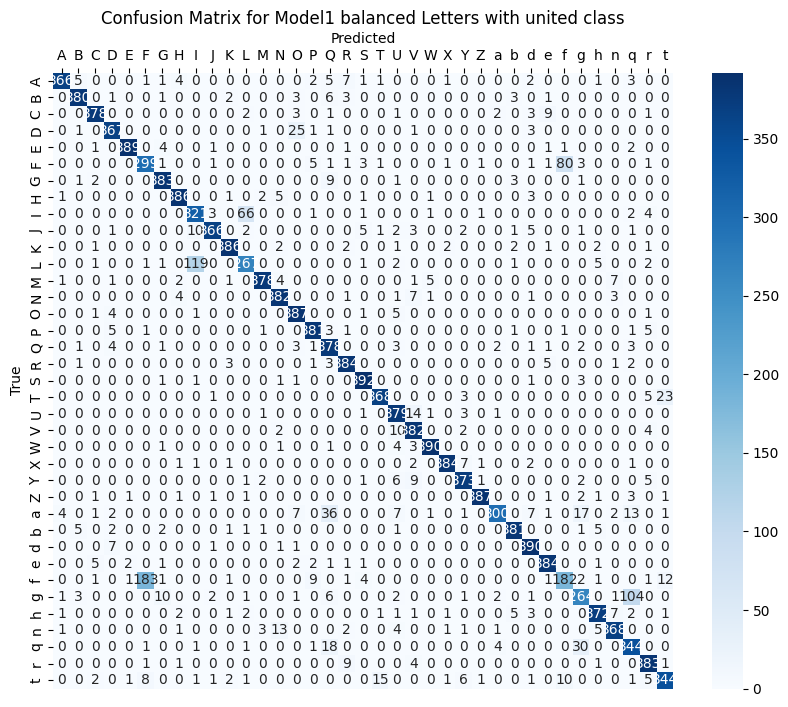

In [60]:
# Predict labels for the test set
predicted_labels = np.argmax(model.predict(test_images, verbose = 0), axis=1)
# Convert numerical labels to characters
predicted_chars = [mapping[str(label+10)] for label in predicted_labels]
true_chars = [mapping[str(label+10)] for label in test_labels]

conf_matrix = confusion_matrix(true_chars, predicted_chars)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(list(set(predicted_chars))), yticklabels=sorted(list(set(true_chars))))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Model1 balanced Letters with united class')
plt.gca().xaxis.tick_top()  # Move x-axis to top
plt.gca().xaxis.set_label_position('top')  # Move x-axis label to top
plt.show()

f and F, which we dont care about, and again l and I and g and q. How can we improve a bit?

#### More epochs



Epoch 1/15
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9257 - loss: 0.2066 - val_accuracy: 0.9076 - val_loss: 0.2880
Epoch 2/15
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9309 - loss: 0.1933 - val_accuracy: 0.9068 - val_loss: 0.2826
Epoch 3/15
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9344 - loss: 0.1763 - val_accuracy: 0.9053 - val_loss: 0.2926
Epoch 4/15
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9375 - loss: 0.1660 - val_accuracy: 0.9066 - val_loss: 0.2958
Epoch 5/15
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9424 - loss: 0.1537 - val_accuracy: 0.9078 - val_loss: 0.2954
Epoch 6/15
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9444 - loss: 0.1457 - val_accuracy: 0.9086 - val_loss: 0.2971
Epoch 7/15
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9487 - loss: 0.1342 - val_accuracy: 0.9086 - val_loss: 0.3188
Epoch 8/15
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9484 - loss: 0.1284 - 

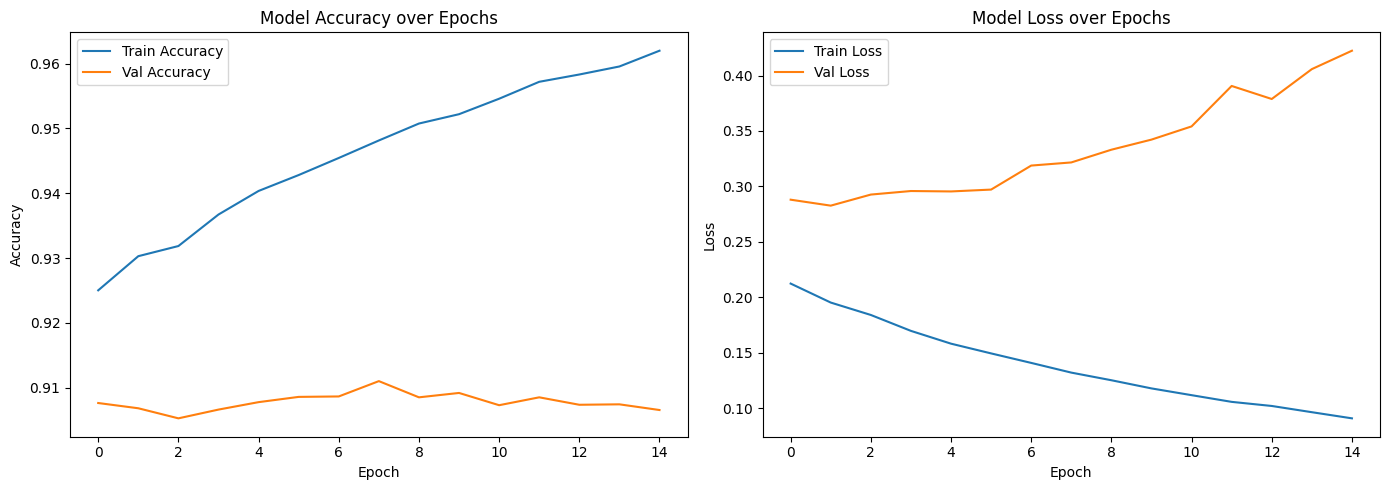

In [61]:

# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Ok seems that 10(?) would be enough. What about adding learning rate?

#### Learning rate

In [65]:
from tensorflow.keras.optimizers import Adam

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(37, activation='softmax')  # 37 distinct letters
])

# Decrease the learning rate
optimizer = Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_images, train_labels, epochs=20, batch_size=64, validation_data=(test_images, test_labels))

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f'\nTest accuracy: {test_acc}')



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.3777 - loss: 2.3328 - val_accuracy: 0.7365 - val_loss: 0.9302
Epoch 2/20
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.7627 - loss: 0.8148 - val_accuracy: 0.8074 - val_loss: 0.6611
Epoch 3/20
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8257 - loss: 0.5907 - val_accuracy: 0.8311 - val_loss: 0.5695
Epoch 4/20
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8477 - loss: 0.5004 - val_accuracy: 0.8501 - val_loss: 0.5035
Epoch 5/20
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8605 - loss: 0.4512 - val_accuracy: 0.8590 - val_loss: 0.4620
Epoch 6/20
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8745 - loss: 0.4084 - val_accuracy: 0.8675 - val_loss: 0.4303
Epoch 7/20
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8797 - loss: 0.3827 - val_accuracy: 0.8711 - val_loss: 0.4230
Epoch 8/20
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8875 - loss: 0.3634 - 

It did not help too much.

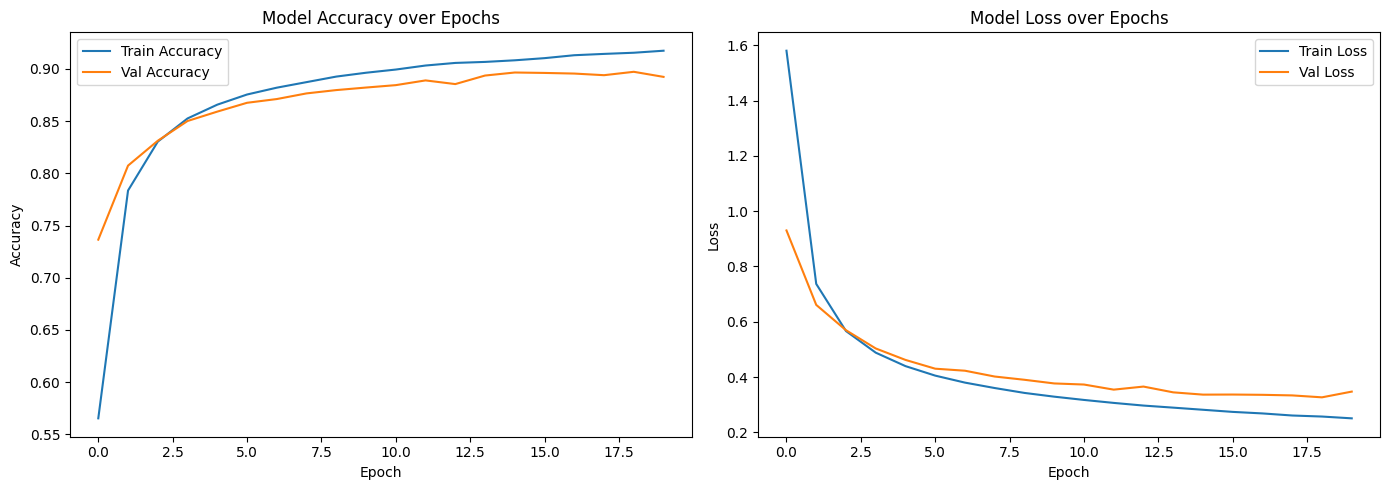

In [66]:
#todiscuss remove this cell?
# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

#### Augmentation of data

In [10]:
train_images.shape

(88799, 28, 28)

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Reshape to add channel dimension
train_images = train_images.reshape(-1, 28, 28, 1)
test_images = test_images.reshape(-1, 28, 28, 1)

# # Convert to float32 and normalize
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# Verify the new shapes
print(f"Train images shape: {train_images.shape}")  # Should be (88799, 28, 28, 1)
print(f"Test images shape: {test_images.shape}")    # Should be (number, 28, 28, 1)

# Define data augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)

# Fit the generator to the training data
datagen.fit(train_images)


model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(37, activation='softmax')  # 37 distinct letters
])


model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


# Train the model using the data generator
history = model.fit(datagen.flow(train_images, train_labels, batch_size=64),
                    epochs=20,
                    validation_data=(test_images, test_labels))

Train images shape: (88799, 28, 28, 1)
Test images shape: (14799, 28, 28, 1)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1388/1388 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - accuracy: 0.5252 - loss: 1.6817 - val_accuracy: 0.8680 - val_loss: 0.4181
Epoch 2/20
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 35s 25ms/step - accuracy: 0.8307 - loss: 0.5473 - val_accuracy: 0.8908 - val_loss: 0.3536
Epoch 3/20
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 34s 24ms/step - accuracy: 0.8603 - loss: 0.4426 - val_accuracy: 0.8984 - val_loss: 0.3349
Epoch 4/20
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 44s 32ms/step - accuracy: 0.8720 - loss: 0.3997 - val_accuracy: 0.8992 - val_loss: 0.3221
Epoch 5/20
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 71s 24ms/step - accuracy: 0.8819 - loss: 0.3605 - val_accuracy: 0.8974 - val_loss: 0.3273
Epoch 6/20
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 52s 37ms/step - accuracy: 0.8868 - loss: 0.3450 - val_accuracy: 0.9116 - val_loss: 0.2809
Epoch 7/20
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 41s 29ms/step - accuracy: 0.8930 - loss: 0.3274 - val_accuracy: 0.9093 - val_loss: 0.2850
Epoch 8/20
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 38s 27ms/step - accuracy: 0.8948 - loss: 0.31

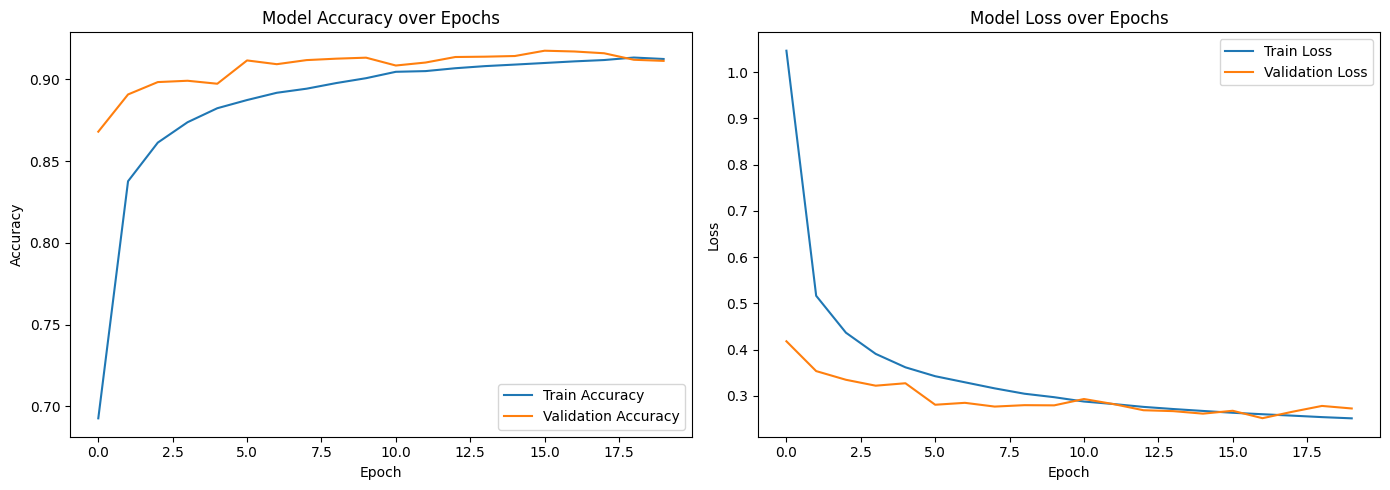

In [12]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


#### Early stopping



In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(37, activation='softmax')  # 37 distinct letters
])


model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_images, train_labels, epochs=20, batch_size=64, validation_data=(test_images, test_labels))

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f'\nTest accuracy: {test_acc}')

# Train the model with early stopping
history = model.fit(
    datagen.flow(train_images, train_labels, batch_size=64),
    epochs=20,
    validation_data=(test_images, test_labels),
    callbacks=[early_stopping]
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.6603 - loss: 1.2088 - val_accuracy: 0.8657 - val_loss: 0.4335
Epoch 2/20
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8886 - loss: 0.3409 - val_accuracy: 0.8959 - val_loss: 0.3323
Epoch 3/20
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9081 - loss: 0.2775 - val_accuracy: 0.9058 - val_loss: 0.3009
Epoch 4/20
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9166 - loss: 0.2417 - val_accuracy: 0.9058 - val_loss: 0.2947
Epoch 5/20
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9222 - loss: 0.2223 - val_accuracy: 0.9082 - val_loss: 0.2825
Epoch 6/20
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9288 - loss: 0.2009 - val_accuracy: 0.9113 - val_loss: 0.2806
Epoch 7/20
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9322 - loss: 0.1876 - val_accuracy: 0.9111 - val_loss: 0.2821
Epoch 8/20
 276/1388 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9379 - loss: 0.1734

#### More complex model


In [ ]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dropout(0.5),

    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(37, activation='softmax')  # Adjust according to num_classes
])

# Compile the updated model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])



# Train the model
history = model.fit(train_images, train_labels, epochs=20, batch_size=64, validation_data=(test_images, test_labels))

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f'\nTest accuracy: {test_acc}')



#### Putting all together

In [ ]:


# 1. Reshape and Normalize
# train_images = train_images.reshape(-1, 28, 28, 1).astype('float32') / 255.0
# test_images = test_images.reshape(-1, 28, 28, 1).astype('float32') / 255.0

# # 2. Data Augmentation
# datagen = ImageDataGenerator(
#     rotation_range=15,
#     zoom_range=0.1,
#     width_shift_range=0.1,
#     height_shift_range=0.1
# )
# datagen.fit(train_images)

# 3. Define Enhanced Model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dropout(0.5),

    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(37, activation='softmax')  # Adjust according to num_classes
])

# 4. Compile the Model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 5. Define Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 6. Train the Model
history = model.fit(
    datagen.flow(train_images, train_labels, batch_size=64),
    epochs=30,
    validation_data=(test_images, test_labels),
    callbacks=[early_stopping]
)

# 7. Plot Training History
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# 8. Evaluate the Model
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f'\nTest accuracy: {test_acc}')

# 9. Classification Report
from sklearn.metrics import classification_report

predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)
print(classification_report(test_labels, predicted_labels))


In [49]:
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

In [ ]:

# Normalize the images
train_images = train_images / 255.0
test_images = test_images / 255.0

# Ensure train_labels are in the correct range (0-36)
print(np.unique(train_labels))  # Check unique values

# CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(37, activation='softmax')  # 36 letters + 1 for unknown
])

# Compile the model with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(train_images, train_labels, epochs=5, batch_size=64, validation_data=(test_images, test_labels))

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f'\nTest accuracy: {test_acc}')

[10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33
 34 35 36 37 38 39 40 41 42 43 44 45 46]
Epoch 1/5
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.0275 - loss: nan - val_accuracy: 0.0270 - val_loss: nan
Epoch 2/5
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.0276 - loss: nan - val_accuracy: 0.0270 - val_loss: nan
Epoch 3/5
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.0270 - loss: nan - val_accuracy: 0.0270 - val_loss: nan
Epoch 4/5
1138/1388 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0261 - loss: nan

In [ ]:
train_images[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   4,
          9,  32,  37,  21,   3,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   7,  46, 114,
        140, 204, 215, 170,  78,   7,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   7,  90, 207, 244,
        246, 249, 250, 251, 206,  46,   8,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   3,  27, 186, 231, 204,
        140, 127, 141, 222, 245, 128,  47,   1,   0,   0,   0,   0,   0,
          0,   0],
       [  

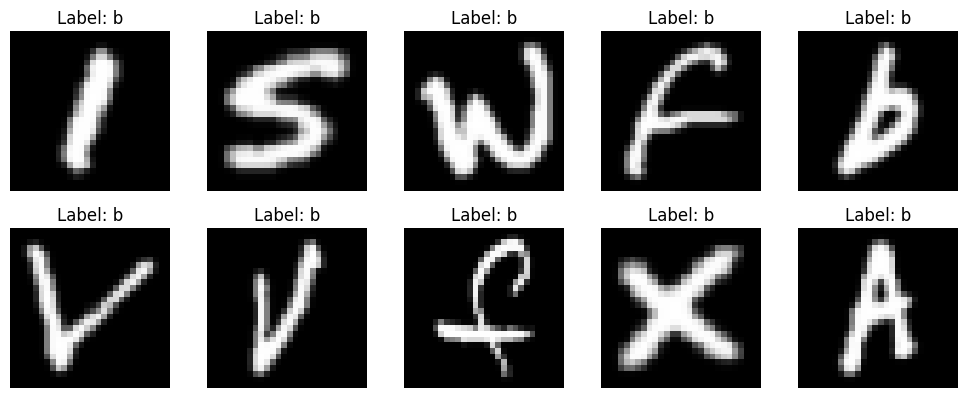

In [ ]:
def plot_random_images(images, labels, mapping, num_images=10):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        # Select a random index
        idx = np.random.randint(0, len(images))

        # Get the corresponding image and label
        img = images[idx]
        label = labels[idx]

        # Map label to character using the dictionary
        label_char = mapping.get(label, 'b')  # '?' for unmapped labels

        # Plot the image with label
        plt.subplot(5, 5, i + 1)  # Adjust rows/cols based on num_images
        plt.imshow(img.squeeze(), cmap='gray')  # Squeeze to remove single channel dimension if present
        plt.title(f"Label: {label_char}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function with your data
plot_random_images(train_images, train_labels, mapping, num_images=10)

In [ ]:
len(np.unique(train_labels))

37

G


(-0.5, 27.5, 27.5, -0.5)

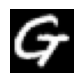

In [ ]:
idx = 8
print(mapping[str(test_labels[idx])])



plt.subplot(5, 5, 1)  # Adjust rows/cols based on num_images
plt.imshow(test_images[idx].squeeze(), cmap='gray')  # Squeeze to remove single channel dimension if present
# plt.title(f"Label: {label_char}")
plt.axis('off')

In [ ]:
train_images[0]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.01568627, 0.03529412, 0.1254902 ,
        0.14509804, 0.0823

In [ ]:
type(train_labels[0])

np.isnan(train_images).any(), np.isnan(train_labels).any()

(False, False)

In [ ]:
len(np.unique(train_labels))

assert not np.isnan(train_images).any(), "train_images contains NaN values"
assert not np.isnan(train_labels).any(), "train_labels contains NaN values"

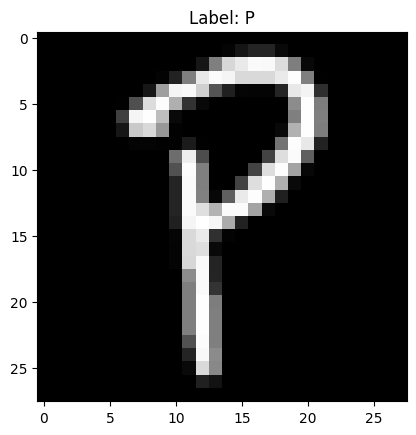

In [ ]:
image_index = 999

# Display the image
plt.imshow(train_images[image_index], cmap='gray')
plt.title(f"Label: {mapping[str(train_labels[image_index])]}") #label into character
plt.show()

## Garbage

In [ ]:

train_images[0]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.01568627, 0.03529412, 0.1254902 ,
        0.14509804, 0.0823

In [ ]:
train_images[0]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.01568627, 0.03529412, 0.1254902 ,
        0.14509804, 0.0823

In [ ]:
u_labels = np.unique(train_labels)

[mapping[str(label)] for label in u_labels]

['A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'a',
 'b',
 'd',
 'e',
 'f',
 'g',
 'h',
 'n',
 'q',
 'r',
 't']

In [ ]:

len( np.unique(train_labels))

37

In [ ]:
mapping['11']

'B'

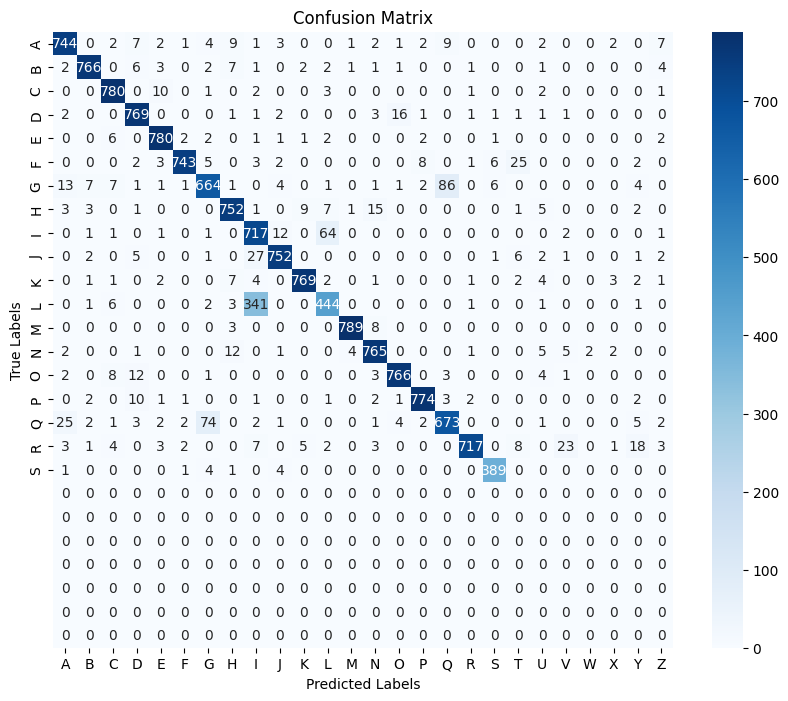

In [ ]:
# prompt: compose a confusion matrix for predicted_chars and true_chars, use sns, but make on graph xlabels above the table not below,

import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Assuming predicted_chars and true_chars are already defined from your previous code

cm = confusion_matrix(true_chars, predicted_chars)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=sorted(list(set(predicted_chars))),
            yticklabels=sorted(list(set(true_chars))))
plt.xlabel("Predicted Labels", position=(1, -0.08)) # Move xlabel above
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

plt.show()

In [ ]:
print(type(train_labels))
print(train_labels.dtype)

<class 'list'>


AttributeError: 'list' object has no attribute 'dtype'

In [ ]:
model.predict(test_images)


463/463 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


array([5.80328408e-09, 1.44100323e-01, 2.87445640e-04, 8.53447818e-06,
       2.12905448e-04, 7.08071730e-06, 1.31880997e-05, 1.01850871e-02,
       1.19760734e-05, 3.88151617e-03, 3.95600982e-02, 8.58923727e-07,
       1.46561419e-04, 7.93771804e-09, 1.02834965e-05, 1.24842418e-05,
       1.04227311e-05, 1.59059593e-03, 4.58554041e-06, 7.84042495e-05,
       3.81872633e-06, 9.59553563e-06, 1.31223669e-06, 1.11857652e-07,
       2.54629384e-04, 3.66517366e-03, 7.95943022e-01], dtype=float32)

In [ ]:
len(pr[0])

27

In [ ]:
predicted_labels = np.argmax(model.predict(test_images), axis=1)

463/463 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [ ]:
# print distinct predicted_labels
print(np.unique(test_labels))


[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
